In [42]:
%load_ext autoreload
%autoreload 2
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
df_raw = load_dataframe()

In [44]:
df_raw.head()

,text,label
0,US trade gap ballooned in October\n\nThe US tr...,business
1,Japanese mogul arrested for fraud\n\nOne of Ja...,business
2,Jarvis sells Tube stake to Spain\n\nShares in ...,business
3,Small firms 'hit by rising costs'\n\nRising fu...,business
4,Oil prices fall back from highs\n\nOil prices ...,business


In [45]:
PREPROCESSING_PIPELINE = [
                        lower,
                        remove_emails,
                        replace_special_characters,
                        replace_br,
                        filter_out_uncommon_symbols,
                        remove_stopwords,
                        strip_text
                    ]

In [46]:
print('Pre-processing text...')
 
print()
print(f'[Debug] Before:\n{df_raw.text.values[0]}')
print()
 
# Replace each sentence with its pre-processed version
df = df_raw.copy()
df['text'] = df_raw['text'].apply(lambda txt: text_prepare(txt, PREPROCESSING_PIPELINE))
 
print(f'[Debug] After:\n{df.text.values[0]}')
print()
 
print("Pre-processing completed!")

Pre-processing text...

[Debug] Before:
US trade gap ballooned in October

The US trade deficit widened by more than expected in October, hitting record levels after higher oil prices raised import costs, figures have shown

The trade shortfall was $55.5bn (£29bn), up 9% from September, the Commerce Department said. That pushed the 10 month deficit to $500.5bn. Imports rose by 3.4%, while exports increased by only 0.6%. A weaker dollar also increased the cost of imports, though this should help drive export demand in coming months. "Things are getting worse, but that's to be expected," said David Wyss of Standard & Poor's in New York. "The first thing is that when the dollar goes down, it increases the price of imports. "We are seeing improved export orders. Things seem to be going in the right direction."

Despite this optimism, significant concerns remain as to how the US will fund its trade and budget deficits should they continue to widen. Another problem highlighted by analysts wa

[Debug] After:
us trade gap ballooned october us trade deficit widened expected october hitting record levels higher oil prices raised import costs figures shown trade shortfall 555bn 29bn 9 september commerce department said pushed 10 month deficit 5005bn imports rose 34 exports increased 06 weaker dollar also increased cost imports though help drive export demand coming months things getting worse thats expected said david wyss standard poors new york first thing dollar goes increases price imports seeing improved export orders things seem going right direction despite optimism significant concerns remain us fund trade budget deficits continue widen another problem highlighted analysts growing trade gap china accused keeping currency artificially weak order boost exports us imported almost 20bn worth goods china october exporting little 3bn seems key worry existed currency market still remains said anthony crescenzi bond strategist miller tabak new york trade deficit shortfall china 

In [47]:
path = 'vocab/'
if not os.path.exists(path):
    os.makedirs(path)

# Check if vocabulary has already been built
vocab_regex = re.compile(r'idx_to_word\.pkl|word_to_idx\.pkl|word_listing\.pkl')

if len(os.listdir(path)) > 0 and all([vocab_regex.search(f) for f in os.listdir(path)]):
    print('Loading existing vocabulary...')
    idx_to_word, word_to_idx, word_listing = load_vocab()
    print('Vocabulary loaded!')
else:
    print('Building vocabulary...')
    idx_to_word, word_to_idx, word_listing = build_vocabulary(df)
    print('Saving vocabulary...')
    save_vocab(idx_to_word, word_to_idx, word_listing)
    print('Vocabulary built!')

Loading existing vocabulary...
Vocabulary loaded!


In [48]:
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, df)

[Vocabulary Evaluation] Size checking...
[Vocabulary Evaluation] Content checking...


100%|██████████| 31579/31579 [00:00<00:00, 680871.25it/s]


[Vocabulary Evaluation] Consistency checking...


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9400.24it/s]


[Vocabulary Evaluation] Toy example checking...


100%|██████████| 2/2 [00:00<00:00, 17476.27it/s]


In [49]:
df_train, df_test = split_dataframe(df)

In [50]:
print(f'Train size: {len(df_train)}')
df_train.head()

Train size: 800


,text,label
0,mary shafer writes 4 apr 1993 203110 0400 pat ...,space
1,chinas great war professor xu guoqi provides o...,historical
2,chancellor rallies labour voters gordon brown ...,politics
3,3 1 2 cups flour 1 cup sugar 1 2 cup butter so...,food
4,eastern fronts 1914 learn war east 1914 easter...,historical


In [51]:
print(f'Test size: {len(df_test)}')
df_test.head()

Test size: 200


,text,label
0,brookside creators channel 4 bid creator defun...,entertainment
1,holmes starts 2005 gb events kelly holmes star...,sport
2,teen ate nothing fries chips junk food years s...,food
3,peace demo appeal rejected peace protestors lo...,politics
4,followup previous reply topic pointed might da...,medical


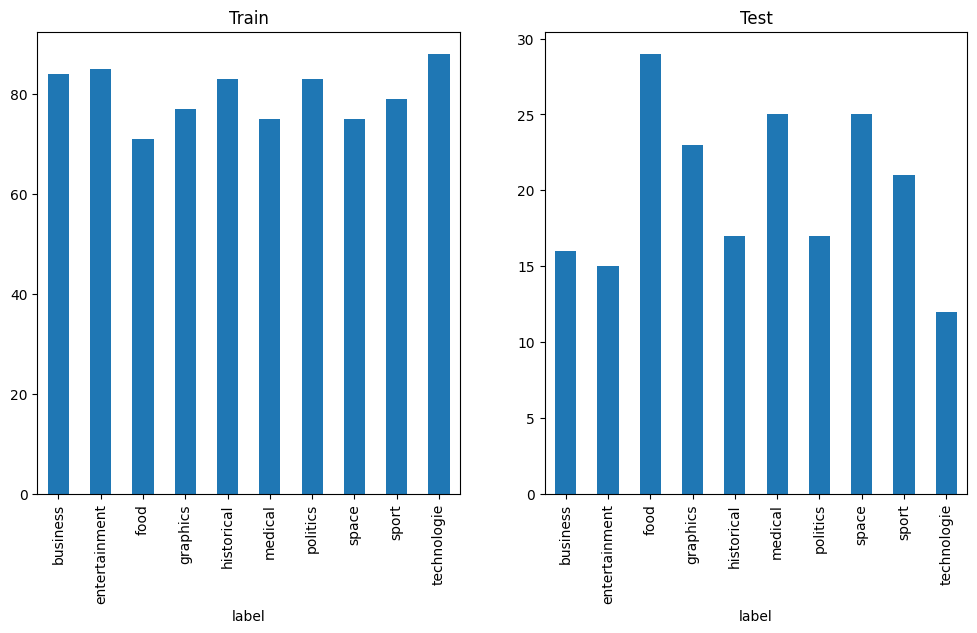

In [52]:
plot_label_distribution([df_train, df_test], labels=['Train', 'Test'])

## PMI

In [53]:
test_text = df_train.text.values[0]
print(f'[Debug] Test text:\n{test_text}')
print()
# TODO: should we remove stopwords here?
processed_text = text_prepare(test_text, PREPROCESSING_PIPELINE)
print(f'[Debug] Pre-processed test text:\n{processed_text}')
pmi, pmi_word_to_idx, pmi_idx_to_word = compute_pmi(processed_text)
print()


[Debug] Test text:
mary shafer writes 4 apr 1993 203110 0400 pat said pat article pat writes question someone give 10 examples direct nasa space related research helped humanity general interesting see pat tang mylar think think also pushed hi tech pat composites airframes look fly wire swept wingsif fly airliners youve reaped benefits didnt one early jet fighters also think germans work wwii winglets area ruling digital fly wire ride smoothing lot also done military microwave landing systems supercritical wings general aviation air foils werent first microwave landing systems wwii mary shafer dod #0362 kotfr nasa dryden flight research facility edwards ca course dont speak nasa mig six better mig unknown us fighter pilot egad im disagreeing mary shafer phil fraering seems like every day find sorts stuff like ancient mayans televison repo man

[Debug] Pre-processed test text:
mary shafer writes 4 apr 1993 203110 0400 pat said pat article pat writes question someone give 10 examples dir

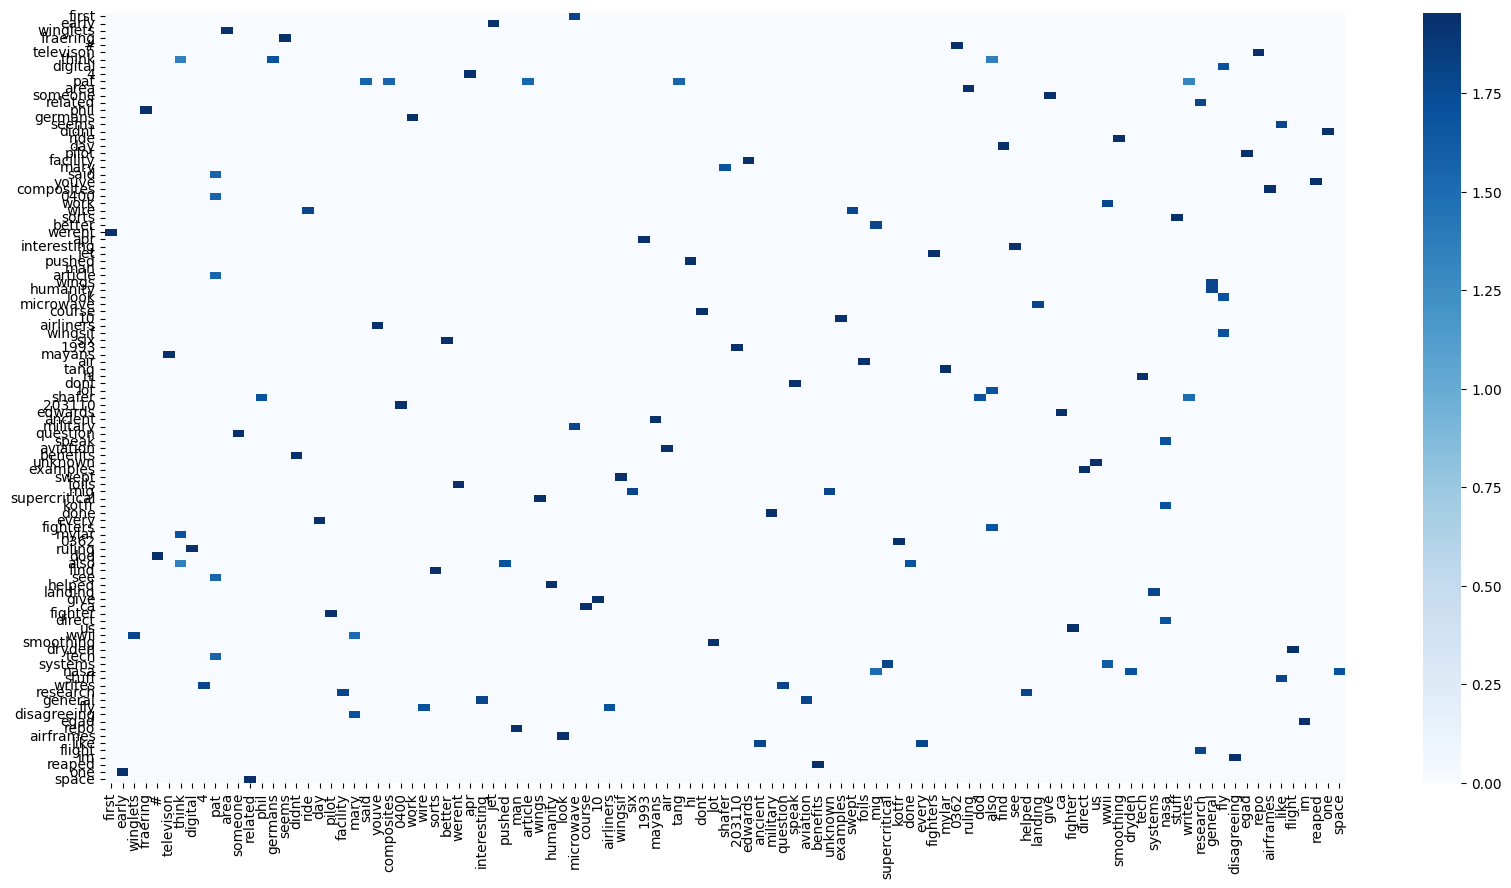

In [54]:
plot_pmi(pmi, pmi_idx_to_word)

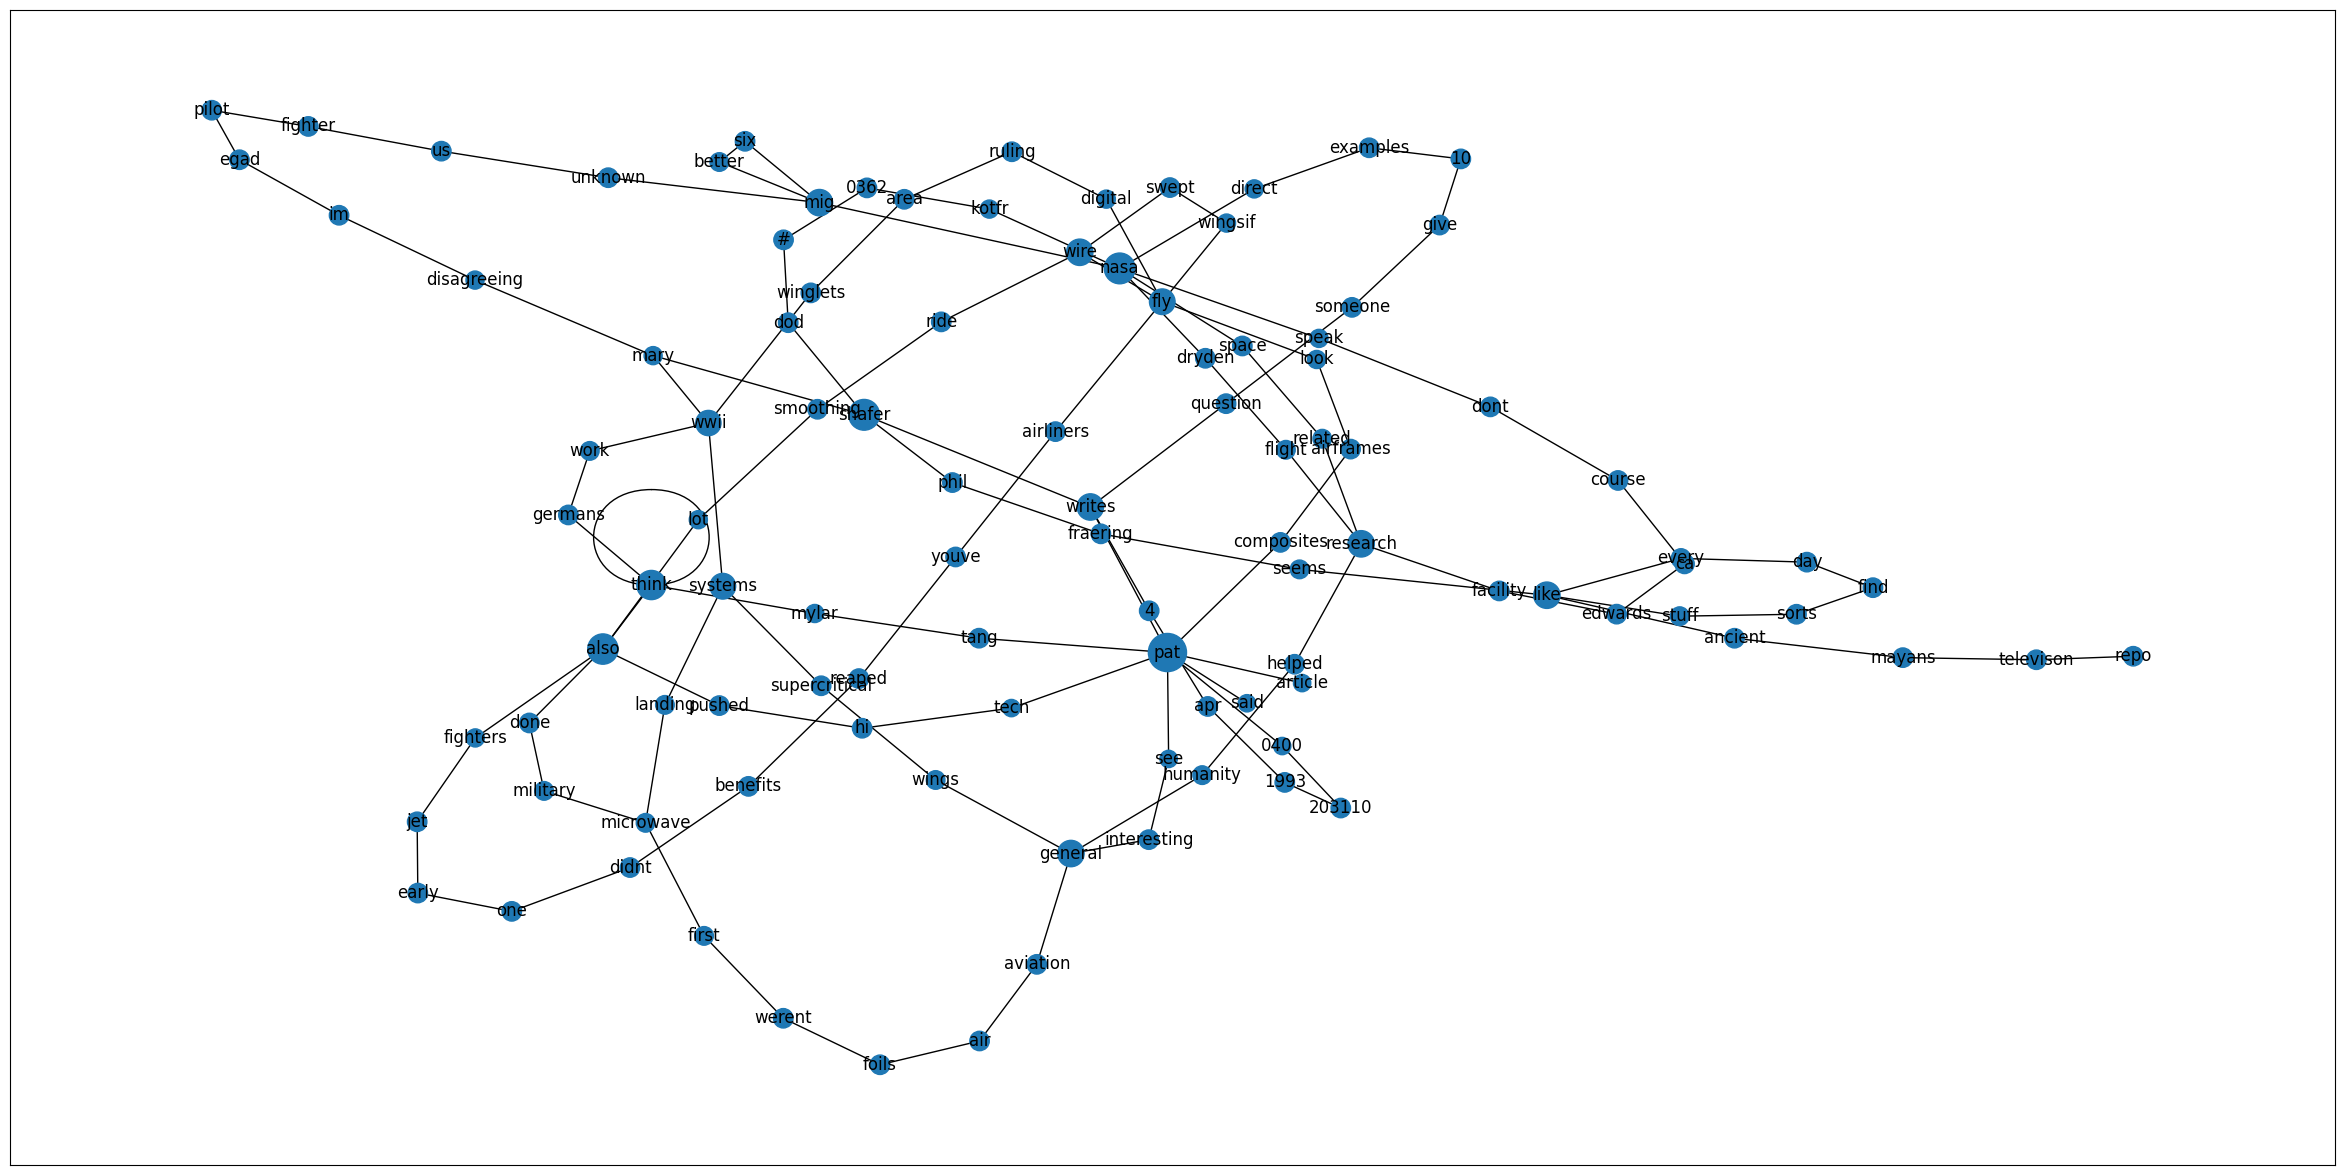

In [55]:
plot_pmi_graph(pmi, pmi_idx_to_word, pmi_word_to_idx)

In [56]:
sorted_pmi_values = sorted(pmi[pmi > 0], reverse=True)

In [57]:
num_values_gt_0 = len(sorted_pmi_values)
print(f'Length of pmi: {len(pmi)}')
print(f'Number of values greater than 0: {num_values_gt_0}')
ratio = 2/3
idx = int(num_values_gt_0 * ratio)
threshold = sorted_pmi_values[idx]
print(f'Threshold: {threshold}')

Length of pmi: 107
Number of values greater than 0: 127
Threshold: 1.8009310209215366


In [58]:
pmi2 = threshold_pmi(pmi, threshold)

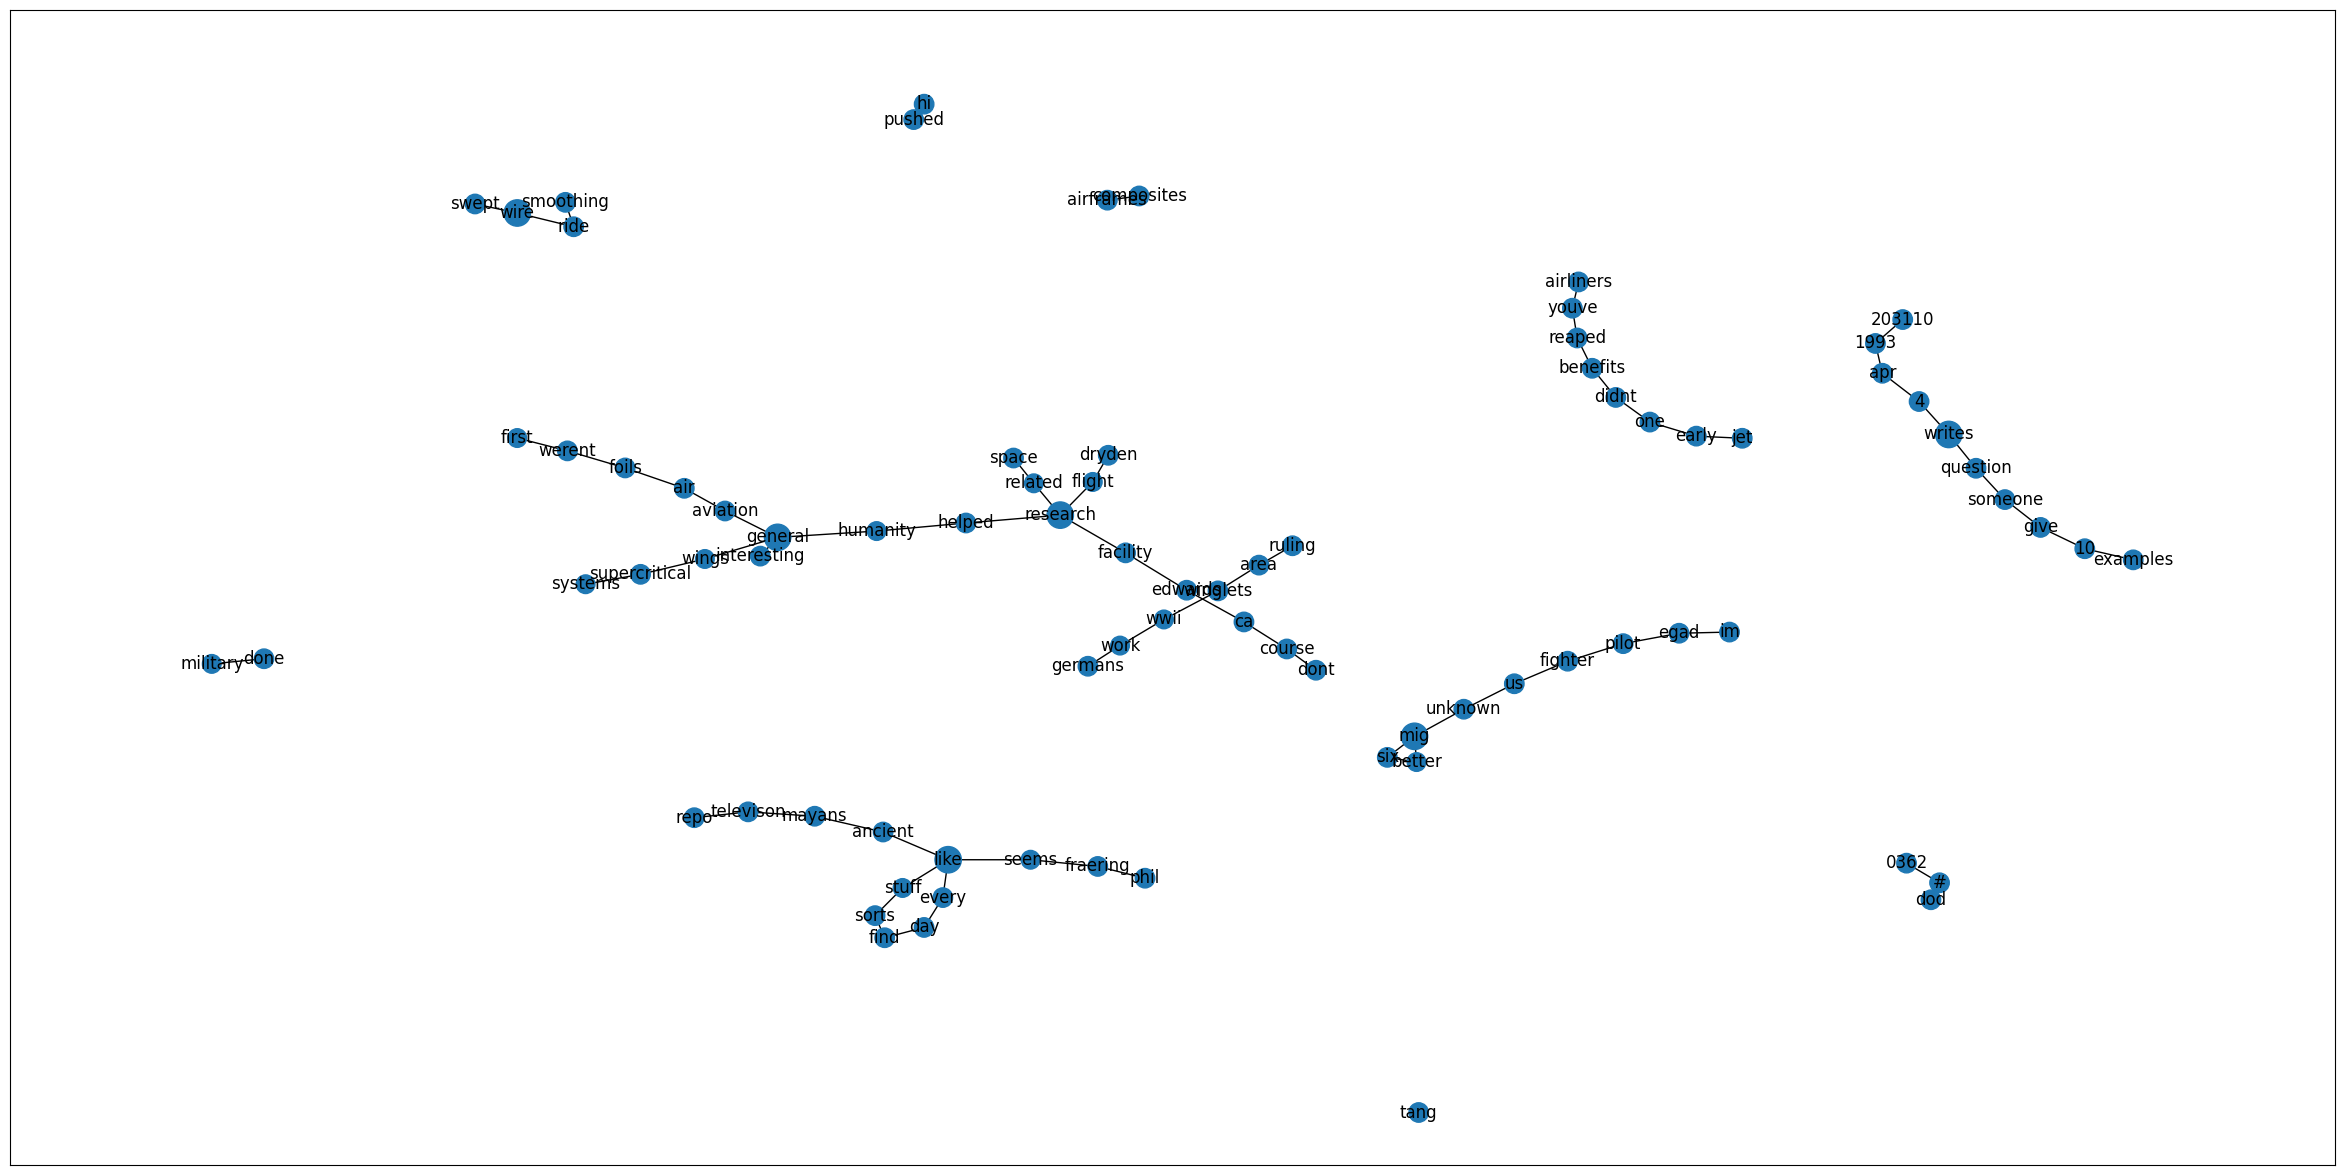

In [59]:
plot_pmi_graph(pmi2, pmi_idx_to_word, pmi_word_to_idx)

In [65]:
def compute_centrality(pmi_matrix):
    G = nx.from_numpy_array(pmi_matrix)
    return G,nx.degree_centrality(G)

G, centrality = compute_centrality(pmi2)


107
107
Graph with 107 nodes and 88 edges


In [ ]:
import sklearn
from sklearn import cluster

test_text = df_train.text.values[:2]

pmi_matrices = []
for text in test_text:
  pmi, pmi_word_to_idx, pmi_idx_to_word = compute_pmi(text)
  pmi_matrices.append(pmi)

# Construct a similarity matrix from the PMI matrices
similarity_matrix = np.zeros((len(pmi_matrices), len(pmi_matrices)))
for i in range(len(pmi_matrices)):
  for j in range(len(pmi_matrices)):
    similarity_matrix[i, j] = np.linalg.norm(pmi_matrices[i] - pmi_matrices[j])

# Choose a clustering algorithm
kmeans = sklearn.cluster.KMeans(n_clusters=2)

# Apply the clustering algorithm to the similarity matrix
cluster_labels = kmeans.fit_predict(similarity_matrix)

# Print the cluster labels
print(cluster_labels)

ValueError: operands could not be broadcast together with shapes (68,68) (125,125) 

: 